In [7]:
import random, math
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import numpy as np
import copy

from matplotlib import style
style.use('seaborn')

In [8]:
random.seed(42)

In [9]:
def exprand(lambdr):
    return -math.log(1.0 - random.random()) / lambdr

print(exprand(1/5))
print(np.random.exponential(5))

5.1003014363740045
1.8743245094690453


In [10]:
a = []
b = []
for i in range(100000):
    a.append(np.random.exponential(5))
    b.append(exprand(1/5))
print(statistics.mean(a))
print(statistics.mean(b))

4.990970208133544
5.0074373915680574


In [45]:
def exprand(lambdr):
    return -math.log(1.0 - random.random()) / lambdr

class Customer:
    def __init__(self, customer_id, y, time_to_process_this_customer):
        self.customer_id = customer_id  # номер человека
        self.y = y # время, через которое он придет
        self.check_in_time = 0 #время, в которое он придет
        self.time_to_process_this_customer = time_to_process_this_customer # время на обработку этого человека (+1 временное решение того, что 0 требуется на процесс)
        self.in_progress = False
        self.spent_time=0

# Обработчик
class Handler:
    def __init__(self, id):
        self.id = id
        self.powerness = 1.0
        self.tmp_powerness = self.powerness

    def process_customer(self, list_of_customers):
        if (list_of_customers is not None):
            self.tmp_powerness = self.powerness
            tmp_powerness_ = self.tmp_powerness
            for i in list_of_customers:
                if i.time_to_process_this_customer >=0:
                    if self.tmp_powerness > 0:
                        print(f'first, id= {self.id},tmp_powerness= {self.tmp_powerness}, time_to_process= {i.time_to_process_this_customer}, tmp_powerness_= {tmp_powerness_},tmp_powerness= {self.tmp_powerness}')
                        tmp_powerness_-= i.time_to_process_this_customer
                        i.time_to_process_this_customer -= self.tmp_powerness
                        self.tmp_powerness = tmp_powerness_
                        i.in_progress = True
                        i.spent_time+=1
                        print(f'second, id= {self.id},tmp_powerness= {self.tmp_powerness}, time_to_process= {i.time_to_process_this_customer}, tmp_powerness_= {tmp_powerness_},tmp_powerness= {self.tmp_powerness}')
                        
    def get_tmp_powerness(self):
        return self.tmp_powerness
    
    def get_powerness(self):
        return self.powerness

In [46]:
# Вeликий обрабатор!
class MainHandler:
    def __init__(self, number_of_handlers, lambda_, nu):
        self.number_of_handlers = number_of_handlers
        #self.number_of_customers = number_of_customers
        self.list_of_customers = []
        self.list_of_tmp_customers = []
        self.list_of_handlers = []
        self.number_of_customers_left  = 0
        self.customers_growth = []
        self.customers_all = 0
        self.mean_time_spent = []
        self.handler_load = []
        self.lambda_ = lambda_
        self.nu = nu
        
    def get_next(self, customer_id, lambd,nu):
        # Устанавливаем номер человека
        # время, через котрое он придет
        # и время, которое требуется на его обработку
        customer = Customer(customer_id, abs(exprand(1/lambd)), abs(exprand(nu)))
    
        return customer
    
    def generate_customers(self, steps):
        lost_time = steps  # оставшееся количество шагов == время для генерации

        customer_id = 0
        while (lost_time > 0):
            customer_id += 1
            customer = self.get_next(customer_id, self.lambda_, self.nu)
            lost_time -= customer.y
            customer.check_in_time = round(steps - lost_time)
            self.list_of_customers.append(customer)

        #print("Number of customers:" + str(len(self.list_of_customers)))
        #for customer in self.list_of_customers:
            #print("check_in_time: "+str(customer.check_in_time) + " and time_to_process_this_customer:" + str(customer.time_to_process_this_customer))

    def start(self, steps):
        self.generate_customers(steps)
        
        for i in range(self.number_of_handlers):
            self.list_of_handlers.append(Handler(i))

        for i in range(steps):
            new_customers = [customer for customer in self.list_of_customers if customer.check_in_time == i]
            
            # save customers number
            self.customers_all += len(new_customers)
            self.customers_growth.append(self.customers_all)
            
            for customer in new_customers:
                self.list_of_tmp_customers.append(customer)
            
            new_customers = copy.deepcopy(self.list_of_tmp_customers)
            self.list_of_tmp_customers.clear()
            
            # обрабатываем людей
            for handler in self.list_of_handlers:
                handler.process_customer(new_customers)
        
            number_of_working_handlers = 0
            for handler in self.list_of_handlers:
                if handler.get_tmp_powerness() != handler.get_powerness():
                    number_of_working_handlers += 1
            
            self.handler_load.append(number_of_working_handlers)
            
            for j in new_customers:
                if j.time_to_process_this_customer <= 0:
                        self.mean_time_spent.append(j.spent_time)
                        new_customers.remove(j)
            
            for j in new_customers:
                if j.in_progress is False:
                    self.number_of_customers_left+=1
                else:
                    self.list_of_tmp_customers.append(j)
                
            # продолжаем

    # statistics
    def get_customers(self):
        return self.list_of_customers
    
    # количество пришедших кастомеров с начала
    def get_customer_growth(self):
        return self.customers_growth
    
    # Среднее количество НОВЫХ заявок в системе
    def get_mean_customer_growth(self):
        return self.customers_all/len(self.customers_growth)
    
    # количество ОБРАБАТЫВАЕМЫХ заявок в системе
    def get_handler_load(self):
        return self.handler_load
    
    # Среднее количество ОБРАБАТЫВАЕМЫХ заявок в системе
    def get_mean_handler_load(self):
        sum_load = 0
        for load in self.handler_load:
            sum_load += load
        
        return sum_load/len(self.handler_load)
    
    # среднее время пребыания?
    def get_mean_time_spent(self):
        return statistics.mean(self.mean_time_spent)
    
    # вероятность отказа
    def get_deny_probability(self):
        return self.number_of_customers_left/self.customers_all

In [47]:
class Model:
    def __init__(self, number_of_handlers, lambda_, nu):
        self.__handler = MainHandler(number_of_handlers, lambda_, nu)
        self.__time = None
        
    def run(self):
        if self.__time is None or self.__handler is None:
            raise ValueError
        
        self.__handler.start(self.__time)
        
    def set_time(self, time):
        if time <= 0:
            raise ValueError
            
        self.__time = time
        
    def get_time(self):
        return self.__time
    
    def get_handler(self):
        return self.__handler
    
    def set_handler(self, handler):
        self.__handler = handler
    
    handler = property(get_handler, set_handler)
    time = property(get_time, set_time)


In [48]:
# Устанавливаем параметры
'''lambda_ = 1 # интенсивность
nu = 5 #пропускная способность
number_of_handlers = 5 # кол-во обработчиков
random.seed(42)

NUMBER_OF_STEPS = 50*10 # общее количество шагов == времени'''




'lambda_ = 1 # интенсивность\nnu = 5 #пропускная способность\nnumber_of_handlers = 5 # кол-во обработчиков\nrandom.seed(42)\n\nNUMBER_OF_STEPS = 50*10 # общее количество шагов == времени'

In [49]:
model = Model(5, 1, 5)

In [50]:
#main = MainHandler(number_of_handlers, lambda_, nu)
#main.start(NUMBER_OF_STEPS)

model.time = 10000
model.run()

first, id= 0,tmp_powerness= 1.0, time_to_process= 0.019646698242222725, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.9803533017577772, time_to_process= -0.9803533017577772, tmp_powerness_= 0.9803533017577772,tmp_powerness= 0.9803533017577772
first, id= 0,tmp_powerness= 0.9803533017577772, time_to_process= 0.005821744643897996, tmp_powerness_= 0.9803533017577772,tmp_powerness= 0.9803533017577772
second, id= 0,tmp_powerness= 0.9745315571138793, time_to_process= -0.9745315571138793, tmp_powerness_= 0.9745315571138793,tmp_powerness= 0.9745315571138793
first, id= 0,tmp_powerness= 0.9745315571138793, time_to_process= 0.3893350734525459, tmp_powerness_= 0.9745315571138793,tmp_powerness= 0.9745315571138793
second, id= 0,tmp_powerness= 0.5851964836613334, time_to_process= -0.5851964836613334, tmp_powerness_= 0.5851964836613334,tmp_powerness= 0.5851964836613334
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.13584959013221648, tmp_powerness_= 1.0,tmp_powerness= 1.0
s

second, id= 0,tmp_powerness= 0.8685327871572583, time_to_process= -0.8685327871572583, tmp_powerness_= 0.8685327871572583,tmp_powerness= 0.8685327871572583
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.865545546814498, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.13445445318550198, time_to_process= -0.13445445318550198, tmp_powerness_= 0.13445445318550198,tmp_powerness= 0.13445445318550198
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.07817127142798388, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.9218287285720161, time_to_process= -0.9218287285720161, tmp_powerness_= 0.9218287285720161,tmp_powerness= 0.9218287285720161
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.1205019245313402, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.8794980754686598, time_to_process= -0.8794980754686598, tmp_powerness_= 0.8794980754686598,tmp_powerness= 0.8794980754686598
first, id= 0,tmp_powerness= 1.0, time_to_proc

first, id= 0,tmp_powerness= 1.0, time_to_process= 0.2806103985709165, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.7193896014290835, time_to_process= -0.7193896014290835, tmp_powerness_= 0.7193896014290835,tmp_powerness= 0.7193896014290835
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.013078139238859301, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.9869218607611407, time_to_process= -0.9869218607611407, tmp_powerness_= 0.9869218607611407,tmp_powerness= 0.9869218607611407
first, id= 0,tmp_powerness= 0.9869218607611407, time_to_process= 0.22913898826620144, tmp_powerness_= 0.9869218607611407,tmp_powerness= 0.9869218607611407
second, id= 0,tmp_powerness= 0.7577828724949394, time_to_process= -0.7577828724949394, tmp_powerness_= 0.7577828724949394,tmp_powerness= 0.7577828724949394
first, id= 0,tmp_powerness= 0.7577828724949394, time_to_process= 0.01635845909803391, tmp_powerness_= 0.7577828724949394,tmp_powerness= 0.7577828724949394
se

first, id= 0,tmp_powerness= 1.0, time_to_process= 1.1527005462988504, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= -0.15270054629885044, time_to_process= 0.15270054629885044, tmp_powerness_= -0.15270054629885044,tmp_powerness= -0.15270054629885044
first, id= 1,tmp_powerness= 1.0, time_to_process= 0.15270054629885044, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 1,tmp_powerness= 0.8472994537011496, time_to_process= -0.8472994537011496, tmp_powerness_= 0.8472994537011496,tmp_powerness= 0.8472994537011496
first, id= 1,tmp_powerness= 0.8472994537011496, time_to_process= 0.24127740043382503, tmp_powerness_= 0.8472994537011496,tmp_powerness= 0.8472994537011496
second, id= 1,tmp_powerness= 0.6060220532673245, time_to_process= -0.6060220532673245, tmp_powerness_= 0.6060220532673245,tmp_powerness= 0.6060220532673245
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.07286379102227808, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.92713620897

first, id= 0,tmp_powerness= 1.0, time_to_process= 0.41601196436695653, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.5839880356330435, time_to_process= -0.5839880356330435, tmp_powerness_= 0.5839880356330435,tmp_powerness= 0.5839880356330435
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.270553461349302, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.729446538650698, time_to_process= -0.729446538650698, tmp_powerness_= 0.729446538650698,tmp_powerness= 0.729446538650698
first, id= 0,tmp_powerness= 0.729446538650698, time_to_process= 0.09935931973028526, tmp_powerness_= 0.729446538650698,tmp_powerness= 0.729446538650698
second, id= 0,tmp_powerness= 0.6300872189204128, time_to_process= -0.6300872189204128, tmp_powerness_= 0.6300872189204128,tmp_powerness= 0.6300872189204128
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.32959662643304555, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.6704033735669545, time_to

first, id= 0,tmp_powerness= 1.0, time_to_process= 0.8929611716852957, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.10703882831470435, time_to_process= -0.10703882831470435, tmp_powerness_= 0.10703882831470435,tmp_powerness= 0.10703882831470435
first, id= 0,tmp_powerness= 0.10703882831470435, time_to_process= 0.31219162489056085, tmp_powerness_= 0.10703882831470435,tmp_powerness= 0.10703882831470435
second, id= 0,tmp_powerness= -0.2051527965758565, time_to_process= 0.2051527965758565, tmp_powerness_= -0.2051527965758565,tmp_powerness= -0.2051527965758565
first, id= 1,tmp_powerness= 1.0, time_to_process= 0.2051527965758565, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 1,tmp_powerness= 0.7948472034241435, time_to_process= -0.7948472034241435, tmp_powerness_= 0.7948472034241435,tmp_powerness= 0.7948472034241435
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.20654861113559644, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.793451388

second, id= 0,tmp_powerness= 0.4241691877110577, time_to_process= -0.4241691877110577, tmp_powerness_= 0.4241691877110577,tmp_powerness= 0.4241691877110577
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.06223323299947685, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.9377667670005232, time_to_process= -0.9377667670005232, tmp_powerness_= 0.9377667670005232,tmp_powerness= 0.9377667670005232
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.2826210371839995, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.7173789628160006, time_to_process= -0.7173789628160006, tmp_powerness_= 0.7173789628160006,tmp_powerness= 0.7173789628160006
first, id= 0,tmp_powerness= 0.7173789628160006, time_to_process= 0.08515277787136201, tmp_powerness_= 0.7173789628160006,tmp_powerness= 0.7173789628160006
second, id= 0,tmp_powerness= 0.6322261849446386, time_to_process= -0.6322261849446386, tmp_powerness_= 0.6322261849446386,tmp_powerness= 0.6322261849446386
fi

first, id= 0,tmp_powerness= 1.0, time_to_process= 0.0846346580316369, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.915365341968363, time_to_process= -0.915365341968363, tmp_powerness_= 0.915365341968363,tmp_powerness= 0.915365341968363
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.05483445524013282, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.9451655447598671, time_to_process= -0.9451655447598671, tmp_powerness_= 0.9451655447598671,tmp_powerness= 0.9451655447598671
first, id= 0,tmp_powerness= 0.9451655447598671, time_to_process= 0.026158324330156885, tmp_powerness_= 0.9451655447598671,tmp_powerness= 0.9451655447598671
second, id= 0,tmp_powerness= 0.9190072204297103, time_to_process= -0.9190072204297103, tmp_powerness_= 0.9190072204297103,tmp_powerness= 0.9190072204297103
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.13146398533984346, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.8685360146601565, ti

first, id= 0,tmp_powerness= 0.8315841081755164, time_to_process= 0.5651908765977435, tmp_powerness_= 0.8315841081755164,tmp_powerness= 0.8315841081755164
second, id= 0,tmp_powerness= 0.26639323157777295, time_to_process= -0.26639323157777295, tmp_powerness_= 0.26639323157777295,tmp_powerness= 0.26639323157777295
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.16340843275672884, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.8365915672432711, time_to_process= -0.8365915672432711, tmp_powerness_= 0.8365915672432711,tmp_powerness= 0.8365915672432711
first, id= 0,tmp_powerness= 0.8365915672432711, time_to_process= 0.02409900027573658, tmp_powerness_= 0.8365915672432711,tmp_powerness= 0.8365915672432711
second, id= 0,tmp_powerness= 0.8124925669675346, time_to_process= -0.8124925669675346, tmp_powerness_= 0.8124925669675346,tmp_powerness= 0.8124925669675346
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.3251413837476407, tmp_powerness_= 1.0,tmp_powerness= 1.0


second, id= 0,tmp_powerness= 0.46429434392714763, time_to_process= -0.46429434392714763, tmp_powerness_= 0.46429434392714763,tmp_powerness= 0.46429434392714763
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.13690826105103665, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.8630917389489634, time_to_process= -0.8630917389489634, tmp_powerness_= 0.8630917389489634,tmp_powerness= 0.8630917389489634
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.03617561587508941, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.9638243841249106, time_to_process= -0.9638243841249106, tmp_powerness_= 0.9638243841249106,tmp_powerness= 0.9638243841249106
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.0037353274173511767, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.9962646725826488, time_to_process= -0.9962646725826488, tmp_powerness_= 0.9962646725826488,tmp_powerness= 0.9962646725826488
first, id= 0,tmp_powerness= 0.9962646725

second, id= 0,tmp_powerness= 0.7735196039058908, time_to_process= -0.7735196039058908, tmp_powerness_= 0.7735196039058908,tmp_powerness= 0.7735196039058908
first, id= 0,tmp_powerness= 0.7735196039058908, time_to_process= 0.5692338604010251, tmp_powerness_= 0.7735196039058908,tmp_powerness= 0.7735196039058908
second, id= 0,tmp_powerness= 0.20428574350486572, time_to_process= -0.20428574350486572, tmp_powerness_= 0.20428574350486572,tmp_powerness= 0.20428574350486572
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.06039290224877532, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.9396070977512246, time_to_process= -0.9396070977512246, tmp_powerness_= 0.9396070977512246,tmp_powerness= 0.9396070977512246
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.04527337293345764, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.9547266270665423, time_to_process= -0.9547266270665423, tmp_powerness_= 0.9547266270665423,tmp_powerness= 0.954726627066542

first, id= 0,tmp_powerness= 0.7532733909064173, time_to_process= 0.14425654495924747, tmp_powerness_= 0.7532733909064173,tmp_powerness= 0.7532733909064173
second, id= 0,tmp_powerness= 0.6090168459471699, time_to_process= -0.6090168459471699, tmp_powerness_= 0.6090168459471699,tmp_powerness= 0.6090168459471699
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.15405069836494564, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.8459493016350543, time_to_process= -0.8459493016350543, tmp_powerness_= 0.8459493016350543,tmp_powerness= 0.8459493016350543
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.2270444069618176, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.7729555930381824, time_to_process= -0.7729555930381824, tmp_powerness_= 0.7729555930381824,tmp_powerness= 0.7729555930381824
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.02906023753527339, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.9709397624647266,

first, id= 0,tmp_powerness= 1.0, time_to_process= 0.17694955168193482, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.8230504483180652, time_to_process= -0.8230504483180652, tmp_powerness_= 0.8230504483180652,tmp_powerness= 0.8230504483180652
first, id= 0,tmp_powerness= 0.8230504483180652, time_to_process= 0.12446407917262026, tmp_powerness_= 0.8230504483180652,tmp_powerness= 0.8230504483180652
second, id= 0,tmp_powerness= 0.6985863691454449, time_to_process= -0.6985863691454449, tmp_powerness_= 0.6985863691454449,tmp_powerness= 0.6985863691454449
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.06741055166916107, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.9325894483308389, time_to_process= -0.9325894483308389, tmp_powerness_= 0.9325894483308389,tmp_powerness= 0.9325894483308389
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.1000770995941953, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.8999229004058047,

second, id= 0,tmp_powerness= 0.8432550617041024, time_to_process= -0.8432550617041024, tmp_powerness_= 0.8432550617041024,tmp_powerness= 0.8432550617041024
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.44038096369664953, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.5596190363033504, time_to_process= -0.5596190363033504, tmp_powerness_= 0.5596190363033504,tmp_powerness= 0.5596190363033504
first, id= 0,tmp_powerness= 0.5596190363033504, time_to_process= 0.061926896969778863, tmp_powerness_= 0.5596190363033504,tmp_powerness= 0.5596190363033504
second, id= 0,tmp_powerness= 0.49769213933357154, time_to_process= -0.49769213933357154, tmp_powerness_= 0.49769213933357154,tmp_powerness= 0.49769213933357154
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.5087377535538382, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.4912622464461618, time_to_process= -0.4912622464461618, tmp_powerness_= 0.4912622464461618,tmp_powerness= 0.49126224644616

first, id= 0,tmp_powerness= 1.0, time_to_process= 0.5527235668708667, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.44727643312913334, time_to_process= -0.44727643312913334, tmp_powerness_= 0.44727643312913334,tmp_powerness= 0.44727643312913334
first, id= 0,tmp_powerness= 0.44727643312913334, time_to_process= 0.1278364165095141, tmp_powerness_= 0.44727643312913334,tmp_powerness= 0.44727643312913334
second, id= 0,tmp_powerness= 0.31944001661961924, time_to_process= -0.31944001661961924, tmp_powerness_= 0.31944001661961924,tmp_powerness= 0.31944001661961924
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.005317744807896832, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.9946822551921032, time_to_process= -0.9946822551921032, tmp_powerness_= 0.9946822551921032,tmp_powerness= 0.9946822551921032
first, id= 0,tmp_powerness= 0.9946822551921032, time_to_process= 0.261473681640937, tmp_powerness_= 0.9946822551921032,tmp_powerness= 0.99468225519

first, id= 0,tmp_powerness= 1.0, time_to_process= 0.15015891887305483, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.8498410811269452, time_to_process= -0.8498410811269452, tmp_powerness_= 0.8498410811269452,tmp_powerness= 0.8498410811269452
first, id= 0,tmp_powerness= 0.8498410811269452, time_to_process= 0.159454786576279, tmp_powerness_= 0.8498410811269452,tmp_powerness= 0.8498410811269452
second, id= 0,tmp_powerness= 0.6903862945506662, time_to_process= -0.6903862945506662, tmp_powerness_= 0.6903862945506662,tmp_powerness= 0.6903862945506662
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.022984230313384854, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.9770157696866152, time_to_process= -0.9770157696866152, tmp_powerness_= 0.9770157696866152,tmp_powerness= 0.9770157696866152
first, id= 0,tmp_powerness= 0.9770157696866152, time_to_process= 0.07820814351609577, tmp_powerness_= 0.9770157696866152,tmp_powerness= 0.9770157696866152
sec

first, id= 0,tmp_powerness= 1.0, time_to_process= 0.06995830873168365, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.9300416912683164, time_to_process= -0.9300416912683164, tmp_powerness_= 0.9300416912683164,tmp_powerness= 0.9300416912683164
first, id= 0,tmp_powerness= 0.9300416912683164, time_to_process= 0.06476936566699142, tmp_powerness_= 0.9300416912683164,tmp_powerness= 0.9300416912683164
second, id= 0,tmp_powerness= 0.8652723256013249, time_to_process= -0.8652723256013249, tmp_powerness_= 0.8652723256013249,tmp_powerness= 0.8652723256013249
first, id= 0,tmp_powerness= 0.8652723256013249, time_to_process= 0.16348817592217868, tmp_powerness_= 0.8652723256013249,tmp_powerness= 0.8652723256013249
second, id= 0,tmp_powerness= 0.7017841496791463, time_to_process= -0.7017841496791463, tmp_powerness_= 0.7017841496791463,tmp_powerness= 0.7017841496791463
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.03097430101330051, tmp_powerness_= 1.0,tmp_powerness= 1.0
se

first, id= 0,tmp_powerness= 1.0, time_to_process= 0.04013316910526201, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.959866830894738, time_to_process= -0.959866830894738, tmp_powerness_= 0.959866830894738,tmp_powerness= 0.959866830894738
first, id= 0,tmp_powerness= 0.959866830894738, time_to_process= 0.0441660750099048, tmp_powerness_= 0.959866830894738,tmp_powerness= 0.959866830894738
second, id= 0,tmp_powerness= 0.9157007558848332, time_to_process= -0.9157007558848332, tmp_powerness_= 0.9157007558848332,tmp_powerness= 0.9157007558848332
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.23188219774127622, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.7681178022587238, time_to_process= -0.7681178022587238, tmp_powerness_= 0.7681178022587238,tmp_powerness= 0.7681178022587238
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.07605403869731686, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.9239459613026831, time_t

first, id= 0,tmp_powerness= 1.0, time_to_process= 0.09527058971824201, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.904729410281758, time_to_process= -0.904729410281758, tmp_powerness_= 0.904729410281758,tmp_powerness= 0.904729410281758
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.06835918543295147, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.9316408145670485, time_to_process= -0.9316408145670485, tmp_powerness_= 0.9316408145670485,tmp_powerness= 0.9316408145670485
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.11796889329837143, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.8820311067016285, time_to_process= -0.8820311067016285, tmp_powerness_= 0.8820311067016285,tmp_powerness= 0.8820311067016285
first, id= 0,tmp_powerness= 0.8820311067016285, time_to_process= 0.7304130842063157, tmp_powerness_= 0.8820311067016285,tmp_powerness= 0.8820311067016285
second, id= 0,tmp_powerness= 0.15161802249531287, ti

first, id= 0,tmp_powerness= 1.0, time_to_process= 0.3471522075612675, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.6528477924387325, time_to_process= -0.6528477924387325, tmp_powerness_= 0.6528477924387325,tmp_powerness= 0.6528477924387325
first, id= 0,tmp_powerness= 0.6528477924387325, time_to_process= 0.06739503925260508, tmp_powerness_= 0.6528477924387325,tmp_powerness= 0.6528477924387325
second, id= 0,tmp_powerness= 0.5854527531861274, time_to_process= -0.5854527531861274, tmp_powerness_= 0.5854527531861274,tmp_powerness= 0.5854527531861274
first, id= 0,tmp_powerness= 0.5854527531861274, time_to_process= 0.047471966784980744, tmp_powerness_= 0.5854527531861274,tmp_powerness= 0.5854527531861274
second, id= 0,tmp_powerness= 0.5379807864011467, time_to_process= -0.5379807864011467, tmp_powerness_= 0.5379807864011467,tmp_powerness= 0.5379807864011467
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.02820243331947377, tmp_powerness_= 1.0,tmp_powerness= 1.0
se

first, id= 0,tmp_powerness= 1.0, time_to_process= 0.03340613772491199, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.966593862275088, time_to_process= -0.966593862275088, tmp_powerness_= 0.966593862275088,tmp_powerness= 0.966593862275088
first, id= 0,tmp_powerness= 0.966593862275088, time_to_process= 0.07919726588278027, tmp_powerness_= 0.966593862275088,tmp_powerness= 0.966593862275088
second, id= 0,tmp_powerness= 0.8873965963923077, time_to_process= -0.8873965963923077, tmp_powerness_= 0.8873965963923077,tmp_powerness= 0.8873965963923077
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.10482515645352712, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.8951748435464729, time_to_process= -0.8951748435464729, tmp_powerness_= 0.8951748435464729,tmp_powerness= 0.8951748435464729
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.3554197210192809, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.6445802789807191, time_t

first, id= 0,tmp_powerness= 1.0, time_to_process= 0.5745547814919791, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.42544521850802086, time_to_process= -0.42544521850802086, tmp_powerness_= 0.42544521850802086,tmp_powerness= 0.42544521850802086
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.32275410197582666, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.6772458980241733, time_to_process= -0.6772458980241733, tmp_powerness_= 0.6772458980241733,tmp_powerness= 0.6772458980241733
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.020107910025275354, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.9798920899747247, time_to_process= -0.9798920899747247, tmp_powerness_= 0.9798920899747247,tmp_powerness= 0.9798920899747247
first, id= 0,tmp_powerness= 0.9798920899747247, time_to_process= 0.016536633624839234, tmp_powerness_= 0.9798920899747247,tmp_powerness= 0.9798920899747247
second, id= 0,tmp_powerness= 0.96335545634

second, id= 0,tmp_powerness= 0.8911636307014732, time_to_process= -0.8911636307014732, tmp_powerness_= 0.8911636307014732,tmp_powerness= 0.8911636307014732
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.10703026704815174, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.8929697329518482, time_to_process= -0.8929697329518482, tmp_powerness_= 0.8929697329518482,tmp_powerness= 0.8929697329518482
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.4076404073037515, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.5923595926962485, time_to_process= -0.5923595926962485, tmp_powerness_= 0.5923595926962485,tmp_powerness= 0.5923595926962485
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.008604015088384525, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.9913959849116155, time_to_process= -0.9913959849116155, tmp_powerness_= 0.9913959849116155,tmp_powerness= 0.9913959849116155
first, id= 0,tmp_powerness= 1.0, time_to_proce

first, id= 0,tmp_powerness= 1.0, time_to_process= 0.12043198788735268, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.8795680121126473, time_to_process= -0.8795680121126473, tmp_powerness_= 0.8795680121126473,tmp_powerness= 0.8795680121126473
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.11956022650331614, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.8804397734966839, time_to_process= -0.8804397734966839, tmp_powerness_= 0.8804397734966839,tmp_powerness= 0.8804397734966839
first, id= 0,tmp_powerness= 0.8804397734966839, time_to_process= 0.0021798152677119905, tmp_powerness_= 0.8804397734966839,tmp_powerness= 0.8804397734966839
second, id= 0,tmp_powerness= 0.878259958228972, time_to_process= -0.878259958228972, tmp_powerness_= 0.878259958228972,tmp_powerness= 0.878259958228972
first, id= 0,tmp_powerness= 0.878259958228972, time_to_process= 0.34180969720925675, tmp_powerness_= 0.878259958228972,tmp_powerness= 0.878259958228972
second,

first, id= 0,tmp_powerness= 0.6942730426320382, time_to_process= 0.26192064972528284, tmp_powerness_= 0.6942730426320382,tmp_powerness= 0.6942730426320382
second, id= 0,tmp_powerness= 0.4323523929067553, time_to_process= -0.4323523929067553, tmp_powerness_= 0.4323523929067553,tmp_powerness= 0.4323523929067553
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.13421890498185757, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.8657810950181424, time_to_process= -0.8657810950181424, tmp_powerness_= 0.8657810950181424,tmp_powerness= 0.8657810950181424
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.024040728443536573, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.9759592715564634, time_to_process= -0.9759592715564634, tmp_powerness_= 0.9759592715564634,tmp_powerness= 0.9759592715564634
first, id= 0,tmp_powerness= 0.9759592715564634, time_to_process= 0.007984409651658943, tmp_powerness_= 0.9759592715564634,tmp_powerness= 0.9759592715564634


second, id= 0,tmp_powerness= 0.38157440780856383, time_to_process= -0.38157440780856383, tmp_powerness_= 0.38157440780856383,tmp_powerness= 0.38157440780856383
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.07240125242780233, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.9275987475721976, time_to_process= -0.9275987475721976, tmp_powerness_= 0.9275987475721976,tmp_powerness= 0.9275987475721976
first, id= 0,tmp_powerness= 0.9275987475721976, time_to_process= 0.05819516163728572, tmp_powerness_= 0.9275987475721976,tmp_powerness= 0.9275987475721976
second, id= 0,tmp_powerness= 0.8694035859349118, time_to_process= -0.8694035859349118, tmp_powerness_= 0.8694035859349118,tmp_powerness= 0.8694035859349118
first, id= 0,tmp_powerness= 0.8694035859349118, time_to_process= 0.027335035736558728, tmp_powerness_= 0.8694035859349118,tmp_powerness= 0.8694035859349118
second, id= 0,tmp_powerness= 0.8420685501983531, time_to_process= -0.8420685501983531, tmp_powerness_= 0.84

second, id= 0,tmp_powerness= 0.986584499538258, time_to_process= -0.986584499538258, tmp_powerness_= 0.986584499538258,tmp_powerness= 0.986584499538258
first, id= 0,tmp_powerness= 0.986584499538258, time_to_process= 0.04682269469370841, tmp_powerness_= 0.986584499538258,tmp_powerness= 0.986584499538258
second, id= 0,tmp_powerness= 0.9397618048445496, time_to_process= -0.9397618048445496, tmp_powerness_= 0.9397618048445496,tmp_powerness= 0.9397618048445496
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.0063181004904504, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.9936818995095495, time_to_process= -0.9936818995095495, tmp_powerness_= 0.9936818995095495,tmp_powerness= 0.9936818995095495
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.34997955678511644, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.6500204432148835, time_to_process= -0.6500204432148835, tmp_powerness_= 0.6500204432148835,tmp_powerness= 0.6500204432148835
first, id

first, id= 0,tmp_powerness= 1.0, time_to_process= 0.03297286858343176, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.9670271314165683, time_to_process= -0.9670271314165683, tmp_powerness_= 0.9670271314165683,tmp_powerness= 0.9670271314165683
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.07762783286147622, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.9223721671385238, time_to_process= -0.9223721671385238, tmp_powerness_= 0.9223721671385238,tmp_powerness= 0.9223721671385238
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.11256290484539966, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.8874370951546003, time_to_process= -0.8874370951546003, tmp_powerness_= 0.8874370951546003,tmp_powerness= 0.8874370951546003
first, id= 0,tmp_powerness= 0.8874370951546003, time_to_process= 0.19943699313518493, tmp_powerness_= 0.8874370951546003,tmp_powerness= 0.8874370951546003
second, id= 0,tmp_powerness= 0.6880001020194154

first, id= 0,tmp_powerness= 1.0, time_to_process= 0.407690476813597, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.5923095231864031, time_to_process= -0.5923095231864031, tmp_powerness_= 0.5923095231864031,tmp_powerness= 0.5923095231864031
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.13113845463618604, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.868861545363814, time_to_process= -0.868861545363814, tmp_powerness_= 0.868861545363814,tmp_powerness= 0.868861545363814
first, id= 0,tmp_powerness= 0.868861545363814, time_to_process= 0.15036980470501712, tmp_powerness_= 0.868861545363814,tmp_powerness= 0.868861545363814
second, id= 0,tmp_powerness= 0.7184917406587968, time_to_process= -0.7184917406587968, tmp_powerness_= 0.7184917406587968,tmp_powerness= 0.7184917406587968
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.00027649306604160084, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.9997235069339584, time

second, id= 0,tmp_powerness= 0.7628616631799576, time_to_process= -0.7628616631799576, tmp_powerness_= 0.7628616631799576,tmp_powerness= 0.7628616631799576
first, id= 0,tmp_powerness= 0.7628616631799576, time_to_process= 0.1845343137423907, tmp_powerness_= 0.7628616631799576,tmp_powerness= 0.7628616631799576
second, id= 0,tmp_powerness= 0.5783273494375669, time_to_process= -0.5783273494375669, tmp_powerness_= 0.5783273494375669,tmp_powerness= 0.5783273494375669
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.10479350650895591, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.8952064934910441, time_to_process= -0.8952064934910441, tmp_powerness_= 0.8952064934910441,tmp_powerness= 0.8952064934910441
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.38309308874034415, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.6169069112596559, time_to_process= -0.6169069112596559, tmp_powerness_= 0.6169069112596559,tmp_powerness= 0.6169069112596559
fi

second, id= 0,tmp_powerness= 0.26176176021571385, time_to_process= -0.26176176021571385, tmp_powerness_= 0.26176176021571385,tmp_powerness= 0.26176176021571385
first, id= 0,tmp_powerness= 1.0, time_to_process= 1.3273967093942478, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= -0.3273967093942478, time_to_process= 0.3273967093942478, tmp_powerness_= -0.3273967093942478,tmp_powerness= -0.3273967093942478
first, id= 1,tmp_powerness= 1.0, time_to_process= 0.3273967093942478, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 1,tmp_powerness= 0.6726032906057522, time_to_process= -0.6726032906057522, tmp_powerness_= 0.6726032906057522,tmp_powerness= 0.6726032906057522
first, id= 1,tmp_powerness= 0.6726032906057522, time_to_process= 0.11286520388099601, tmp_powerness_= 0.6726032906057522,tmp_powerness= 0.6726032906057522
second, id= 1,tmp_powerness= 0.5597380867247562, time_to_process= -0.5597380867247562, tmp_powerness_= 0.5597380867247562,tmp_powerness= 0.55973808672475

first, id= 0,tmp_powerness= 0.7933026894726887, time_to_process= 0.23782084851767354, tmp_powerness_= 0.7933026894726887,tmp_powerness= 0.7933026894726887
second, id= 0,tmp_powerness= 0.5554818409550151, time_to_process= -0.5554818409550151, tmp_powerness_= 0.5554818409550151,tmp_powerness= 0.5554818409550151
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.5626438705563244, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.43735612944367563, time_to_process= -0.43735612944367563, tmp_powerness_= 0.43735612944367563,tmp_powerness= 0.43735612944367563
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.07305590680864632, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.9269440931913537, time_to_process= -0.9269440931913537, tmp_powerness_= 0.9269440931913537,tmp_powerness= 0.9269440931913537
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.09459446254769224, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.9054055374523

first, id= 0,tmp_powerness= 1.0, time_to_process= 0.5079873312325316, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.4920126687674684, time_to_process= -0.4920126687674684, tmp_powerness_= 0.4920126687674684,tmp_powerness= 0.4920126687674684
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.14815737987339153, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.8518426201266085, time_to_process= -0.8518426201266085, tmp_powerness_= 0.8518426201266085,tmp_powerness= 0.8518426201266085
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.004837351817970176, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.9951626481820298, time_to_process= -0.9951626481820298, tmp_powerness_= 0.9951626481820298,tmp_powerness= 0.9951626481820298
first, id= 0,tmp_powerness= 0.9951626481820298, time_to_process= 0.731435036168259, tmp_powerness_= 0.9951626481820298,tmp_powerness= 0.9951626481820298
second, id= 0,tmp_powerness= 0.2637276120137708, 

second, id= 0,tmp_powerness= 0.8183448197119024, time_to_process= -0.8183448197119024, tmp_powerness_= 0.8183448197119024,tmp_powerness= 0.8183448197119024
first, id= 0,tmp_powerness= 0.8183448197119024, time_to_process= 0.3913533047928718, tmp_powerness_= 0.8183448197119024,tmp_powerness= 0.8183448197119024
second, id= 0,tmp_powerness= 0.42699151491903065, time_to_process= -0.42699151491903065, tmp_powerness_= 0.42699151491903065,tmp_powerness= 0.42699151491903065
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.0872489553430208, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.9127510446569792, time_to_process= -0.9127510446569792, tmp_powerness_= 0.9127510446569792,tmp_powerness= 0.9127510446569792
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.2561171834486785, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.7438828165513215, time_to_process= -0.7438828165513215, tmp_powerness_= 0.7438828165513215,tmp_powerness= 0.7438828165513215


second, id= 0,tmp_powerness= 0.9494490933264456, time_to_process= -0.9494490933264456, tmp_powerness_= 0.9494490933264456,tmp_powerness= 0.9494490933264456
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.05199983067552102, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.948000169324479, time_to_process= -0.948000169324479, tmp_powerness_= 0.948000169324479,tmp_powerness= 0.948000169324479
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.30715270650194676, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.6928472934980532, time_to_process= -0.6928472934980532, tmp_powerness_= 0.6928472934980532,tmp_powerness= 0.6928472934980532
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.49038553687836767, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.5096144631216324, time_to_process= -0.5096144631216324, tmp_powerness_= 0.5096144631216324,tmp_powerness= 0.5096144631216324
first, id= 0,tmp_powerness= 1.0, time_to_process= 

first, id= 0,tmp_powerness= 0.6554707308807947, time_to_process= 0.05155236292889272, tmp_powerness_= 0.6554707308807947,tmp_powerness= 0.6554707308807947
second, id= 0,tmp_powerness= 0.6039183679519019, time_to_process= -0.6039183679519019, tmp_powerness_= 0.6039183679519019,tmp_powerness= 0.6039183679519019
first, id= 0,tmp_powerness= 0.6039183679519019, time_to_process= 0.006180155031291006, tmp_powerness_= 0.6039183679519019,tmp_powerness= 0.6039183679519019
second, id= 0,tmp_powerness= 0.5977382129206109, time_to_process= -0.5977382129206109, tmp_powerness_= 0.5977382129206109,tmp_powerness= 0.5977382129206109
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.18405491930123036, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.8159450806987696, time_to_process= -0.8159450806987696, tmp_powerness_= 0.8159450806987696,tmp_powerness= 0.8159450806987696
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.04160612370868106, tmp_powerness_= 1.0,tmp_powerness= 1.0
s

first, id= 0,tmp_powerness= 0.9853466324383048, time_to_process= 0.28627005866176325, tmp_powerness_= 0.9853466324383048,tmp_powerness= 0.9853466324383048
second, id= 0,tmp_powerness= 0.6990765737765415, time_to_process= -0.6990765737765415, tmp_powerness_= 0.6990765737765415,tmp_powerness= 0.6990765737765415
first, id= 0,tmp_powerness= 0.6990765737765415, time_to_process= 0.452535493175725, tmp_powerness_= 0.6990765737765415,tmp_powerness= 0.6990765737765415
second, id= 0,tmp_powerness= 0.24654108060081653, time_to_process= -0.24654108060081653, tmp_powerness_= 0.24654108060081653,tmp_powerness= 0.24654108060081653
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.05627219498474767, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.9437278050152523, time_to_process= -0.9437278050152523, tmp_powerness_= 0.9437278050152523,tmp_powerness= 0.9437278050152523
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.5311140600226887, tmp_powerness_= 1.0,tmp_powerness= 1.0
s

second, id= 0,tmp_powerness= 0.5189818741993549, time_to_process= -0.5189818741993549, tmp_powerness_= 0.5189818741993549,tmp_powerness= 0.5189818741993549
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.2049702949321175, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.7950297050678825, time_to_process= -0.7950297050678825, tmp_powerness_= 0.7950297050678825,tmp_powerness= 0.7950297050678825
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.49174400244780925, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.5082559975521908, time_to_process= -0.5082559975521908, tmp_powerness_= 0.5082559975521908,tmp_powerness= 0.5082559975521908
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.1888209062905592, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.8111790937094407, time_to_process= -0.8111790937094407, tmp_powerness_= 0.8111790937094407,tmp_powerness= 0.8111790937094407
first, id= 0,tmp_powerness= 1.0, time_to_process

second, id= 0,tmp_powerness= 0.7942332085847489, time_to_process= -0.7942332085847489, tmp_powerness_= 0.7942332085847489,tmp_powerness= 0.7942332085847489
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.14075419797556565, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.8592458020244343, time_to_process= -0.8592458020244343, tmp_powerness_= 0.8592458020244343,tmp_powerness= 0.8592458020244343
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.04061400502236499, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.959385994977635, time_to_process= -0.959385994977635, tmp_powerness_= 0.959385994977635,tmp_powerness= 0.959385994977635
first, id= 0,tmp_powerness= 0.959385994977635, time_to_process= 0.09985894883207418, tmp_powerness_= 0.959385994977635,tmp_powerness= 0.959385994977635
second, id= 0,tmp_powerness= 0.8595270461455609, time_to_process= -0.8595270461455609, tmp_powerness_= 0.8595270461455609,tmp_powerness= 0.8595270461455609
first, i

first, id= 0,tmp_powerness= 1.0, time_to_process= 0.26971227139719123, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.7302877286028088, time_to_process= -0.7302877286028088, tmp_powerness_= 0.7302877286028088,tmp_powerness= 0.7302877286028088
first, id= 0,tmp_powerness= 0.7302877286028088, time_to_process= 0.1753646629339135, tmp_powerness_= 0.7302877286028088,tmp_powerness= 0.7302877286028088
second, id= 0,tmp_powerness= 0.5549230656688953, time_to_process= -0.5549230656688953, tmp_powerness_= 0.5549230656688953,tmp_powerness= 0.5549230656688953
first, id= 0,tmp_powerness= 0.5549230656688953, time_to_process= 0.04965706802005481, tmp_powerness_= 0.5549230656688953,tmp_powerness= 0.5549230656688953
second, id= 0,tmp_powerness= 0.5052659976488405, time_to_process= -0.5052659976488405, tmp_powerness_= 0.5052659976488405,tmp_powerness= 0.5052659976488405
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.34304688823979035, tmp_powerness_= 1.0,tmp_powerness= 1.0
sec

first, id= 0,tmp_powerness= 1.0, time_to_process= 0.12260495956093662, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.8773950404390634, time_to_process= -0.8773950404390634, tmp_powerness_= 0.8773950404390634,tmp_powerness= 0.8773950404390634
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.14667239719394867, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.8533276028060514, time_to_process= -0.8533276028060514, tmp_powerness_= 0.8533276028060514,tmp_powerness= 0.8533276028060514
first, id= 0,tmp_powerness= 0.8533276028060514, time_to_process= 0.009877576923259985, tmp_powerness_= 0.8533276028060514,tmp_powerness= 0.8533276028060514
second, id= 0,tmp_powerness= 0.8434500258827914, time_to_process= -0.8434500258827914, tmp_powerness_= 0.8434500258827914,tmp_powerness= 0.8434500258827914
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.04833646930941859, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.951663530690581

second, id= 0,tmp_powerness= 0.8301311871682838, time_to_process= -0.8301311871682838, tmp_powerness_= 0.8301311871682838,tmp_powerness= 0.8301311871682838
first, id= 0,tmp_powerness= 0.8301311871682838, time_to_process= 0.09738056140257839, tmp_powerness_= 0.8301311871682838,tmp_powerness= 0.8301311871682838
second, id= 0,tmp_powerness= 0.7327506257657055, time_to_process= -0.7327506257657055, tmp_powerness_= 0.7327506257657055,tmp_powerness= 0.7327506257657055
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.07819811725164952, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.9218018827483505, time_to_process= -0.9218018827483505, tmp_powerness_= 0.9218018827483505,tmp_powerness= 0.9218018827483505
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.387705703830484, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.6122942961695159, time_to_process= -0.6122942961695159, tmp_powerness_= 0.6122942961695159,tmp_powerness= 0.6122942961695159
fir

second, id= 0,tmp_powerness= 0.9746710843700015, time_to_process= -0.9746710843700015, tmp_powerness_= 0.9746710843700015,tmp_powerness= 0.9746710843700015
first, id= 0,tmp_powerness= 0.9746710843700015, time_to_process= 0.731566012714201, tmp_powerness_= 0.9746710843700015,tmp_powerness= 0.9746710843700015
second, id= 0,tmp_powerness= 0.24310507165580053, time_to_process= -0.24310507165580053, tmp_powerness_= 0.24310507165580053,tmp_powerness= 0.24310507165580053
first, id= 0,tmp_powerness= 1.0, time_to_process= 0.2755859035479136, tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 0.7244140964520864, time_to_process= -0.7244140964520864, tmp_powerness_= 0.7244140964520864,tmp_powerness= 0.7244140964520864


In [17]:
print(model.handler.get_mean_time_spent())

1.0267584849975406


In [37]:
print(model.handler.number_of_customers_left)
print(model.handler.customers_all)


0
10166


In [38]:
print(model.handler.get_deny_probability())

0.0


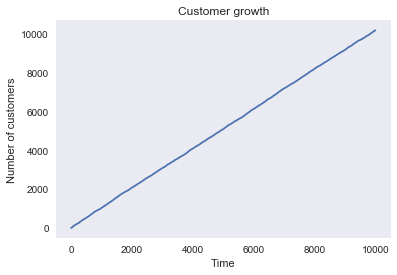

In [39]:
import matplotlib

customers = model.handler.get_customer_growth()

# Data for plotting
x = customers

fig, ax = plt.subplots()
ax.plot(x)

ax.set(xlabel='Time', ylabel='Number of customers',
       title='Customer growth')
ax.grid()

# fig.savefig("Customer_growth.png")
plt.show()

In [40]:
print(model.handler.get_mean_customer_growth())

1.0166


In [41]:
print(model.handler.get_mean_handler_load())

0.666


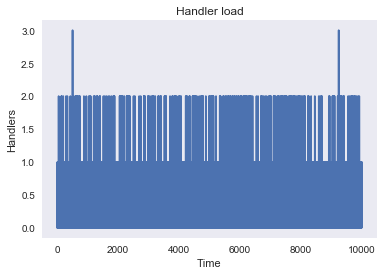

In [42]:
import matplotlib

load = model.handler.get_handler_load()

# Data for plotting
x = load


fig, ax = plt.subplots()

ax.plot(x)

ax.set(xlabel='Time', ylabel='Handlers',
       title='Handler load')
ax.grid()

# fig.savefig("Handler_load.png")
plt.show()

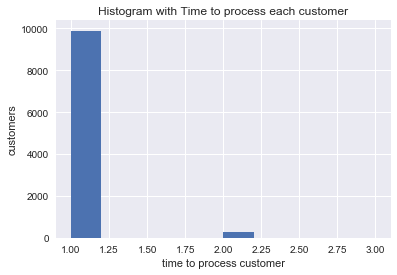

In [43]:
x = model.handler.mean_time_spent

# the histogram of the data
n, bins, patches = plt.hist(x)


plt.xlabel('time to process customer')
plt.ylabel('customers')
plt.title('Histogram with Time to process each customer')

plt.grid(True)
plt.show()

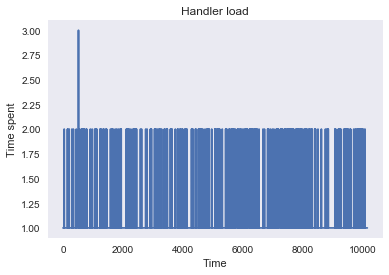

In [44]:
import matplotlib

load = model.handler.mean_time_spent

# Data for plotting
x = load


fig, ax = plt.subplots()
ax.plot(x)

ax.set(xlabel='Time', ylabel='Time spent',
       title='Handler load')
ax.grid()

# fig.savefig("Handler_load.png")
plt.show()

In [26]:
class Theory:
    def __init__(self, number_of_handlers, lambda_, nu):
        self.number_of_handlers = number_of_handlers
        self.lambda_ = lambda_
        self.nu = nu

# вероятность, что k обработчиков заняты
    def get_k_handlers_load_probability(self, k):
        traffic=self.lambda_/self.nu
        return (pow(traffic, k)/math.factorial(k))/(sum(pow(traffic,n)/math.factorial(n) for n in range(0, self.number_of_handlers)))

# вероятность отказа
    def get_loss_probability(self):
        return self.get_k_handlers_load_probability(self.number_of_handlers)

# относительная пропускная способность - вероятность, что заявка будет обслужена
    def get_handle_probability(self):
        return 1 - self.get_loss_probability()

# среднее время поступления заявки
    def get_mean_waiting_time(self):
        return self.lambda_

# среднее время обслуживания
    def get_mean_time_spent(self):
        return 1 / self.nu

# абсолютная пропускная способность - среднее число заявок, обслуживаемых в единицу времени
    def absolute_bandwidth(self):
        return self.lambda_ * self.get_handle_probability()

# число покупалетей за все время
    def get_customers_all(self, steps):
        return self.lambda_ * steps

# среднее число занятых касс - интенсивность потока обслуженных системой заявок (в единицу времени)
    def get_mean_handler_load(self):
        return (sum(n * self.get_k_handlers_load_probability(n) for n in range(0, self.number_of_handlers)))
#        return absolute_bandwidth() / self.nu

    def get_number_of_customers_left(self, steps):
        return self.get_customers_all(steps) * self.get_loss_probability()

In [27]:
theory = Theory(5, 1, 5)

In [28]:
theory.get_k_handlers_load_probability(1)

0.1637465203864418

In [29]:
print(theory.get_loss_probability())
print(model.handler.number_of_customers_left / model.handler.customers_all *100, '%')

2.183286938485891e-06
0.0 %


In [30]:
theory.get_handle_probability()

0.9999978167130615

In [31]:
theory.get_mean_waiting_time()

1

In [32]:
theory.get_mean_time_spent()

0.2

In [33]:
theory.absolute_bandwidth()

0.9999978167130615

In [34]:
theory.get_customers_all(500)

500

In [35]:
theory.get_mean_handler_load()

0.19998908356530756

In [36]:
theory.get_number_of_customers_left(1000)

0.002183286938485891